<a href="https://colab.research.google.com/github/ottermegazord/tf-graphics/blob/master/transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformation with Tensorflow Graphics!

Note: Use TF v.1.14.0

In [1]:
import tensorflow as tf
print(tf.__version__)

1.14.0


## Install tensorflow packages

In [0]:
#!pip install tensorflow==1.14.0
# !pip install tensorflow_graphics

## Import packages

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_graphics.geometry.transformation import quaternion
from tensorflow_graphics.math import vector
from tensorflow_graphics.notebooks import threejs_visualization
from tensorflow_graphics.notebooks.resources import tfg_simplified_logo


In [0]:
# Enable eager execution
tf.enable_eager_execution()

In [0]:
# Load demo pic
vertices = tfg_simplified_logo.mesh['vertices'].astype(np.float32)
faces = tfg_simplified_logo.mesh['faces']
num_vertices = vertices.shape[0]

In [6]:
print(num_vertices)

38


## Modeling

In [0]:
# Create model

model = tf.keras.Sequential([
    
    tf.keras.layers.Flatten(input_shape=(num_vertices, 3)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7)
    
])

## Data Processing

In mathematics, the quaternions are a number system that extends the complex numbers. 

In [0]:
def generate_training_data(num_samples):
  
  # random_angles.shape: (num_samples, 3)
  random_angles = np.random.uniform(-np.pi, np.pi,
                                   (num_samples, 3)).astype(np.float32)
  
  # random_quaternion.shape: (num_samples, 4)
  random_quaternion = quaternion.from_euler(random_angles)
  
  # random_translation.shape: (num_samples, 3)
  random_translation = np.random.uniform(-2.0, 2.0,
                                        (num_samples, 3)).astype(np.float32)
  
  # data.shape: (num_samples, num_vertices, 3)
  data = quaternion.rotate(vertices[tf.newaxis, :, :],
                          random_quaternion[:, tf.newaxis, :]) + random_translation[:, tf.newaxis,:]

  # target.shape: (num_samples, 4+3)
  target = tf.concat((random_quaternion, random_translation), axis=-1)
  
  return np.array(data), np.array(target)
  

In [0]:
NUM_SAMPLES = 10000

# Generate data
data, target = generate_training_data(NUM_SAMPLES)

### Sanity check

In [10]:
print(data.shape)
print(target.shape)

(10000, 38, 3)
(10000, 7)


## Training

### Define pose estimation loss as loss function

We define the
pose estimation loss as the distance between the points sampled on the objects model in ground truth pose and corresponding points on the same model transformed by the
predicted pose. See [paper](http://ai.stanford.edu/~yukez/papers/cvpr2019wang.pdf).

In [0]:
def pose_estimation_loss(y_true, y_pred):
  """
  params: y_true: Ground truth
  params: y_pred: Predicted value
  
  return: Scalar value of pose estimation loss
  """
  
  # y_true.shape: (batch, 7)
  y_true_q, y_true_t = tf.split(y_true, (4,3), axis=-1)
  
  # y_pred.shape: (batch, 7)
  y_pred_q, y_pred_t = tf.split(y_pred, (4, 3), axis=-1)
  
  # vertices.shape: (num_vertices, 3)
  # corners.shape: (num_vertices, 1, 3)
  corners = tf.expand_dims(vertices, axis=1)
  
  # transformed_corners.shape: (num_vertices, batch, 3)
  # pad (standard broadcast) q and t shape with 1's 
  transformed_corners = quaternion.rotate(corners, y_pred_q) + y_pred_t
  
  # recovered_corners.shape: (num_vertices, batch, 3)
  recovered_corners = quaternion.rotate(transformed_corners - y_true_t,
                                        quaternion.inverse(y_true_q))
  
  # vertex_error.shape:(num_vertices, batch)
  vertex_error = tf.reduce_sum((recovered_corners - corners)**2, axis=-1)
  
  return tf.reduce_mean(vertex_error)

In [0]:
model.compile(
    loss=pose_estimation_loss,
    optimizer='adam'
)

### Summary of model

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 114)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                7360      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 11,975
Trainable params: 11,975
Non-trainable params: 0
_________________________________________________________________


### Callbacks

In [0]:
class ProgressLog(tf.keras.callbacks.Callback):
  
  def __init__(self, num_epochs, step=5):
    self.num_epochs = num_epochs
    self.current_epoch = 0
    self.step = step
    self.last_percentage_report = 0
    
  def on_epoch_end(self, batch, logs={}):
    self.current_epoch += 1
    training_percentage = int(self.current_epoch / self.num_epochs * 100)
    
    if training_percentage - self.last_percentage_report >= self.step:
      print('Training ' + str(
          training_percentage) + '% complete. Training loss: ' + str(
              logs.get('loss')) + ' | Validation loss: ' + str(
                  logs.get('val_loss')))
      self.last_percentage_report = training_percentage

In [0]:
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

### Start training!

In [0]:
EPOCHS = 100
pl = ProgressLog(EPOCHS)

In [17]:
history = model.fit(
    data,
    target,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    batch_size=32,
    callbacks=[pl,reduce_lr_callback]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training 5% complete. Training loss: 4.644863576889038 | Validation loss: 4.345002346038818
Training 10% complete. Training loss: 2.3823212385177612 | Validation loss: 2.371367790222168
Training 15% complete. Training loss: 1.5314404339790344 | Validation loss: 1.5466568603515625
Training 20% complete. Training loss: 1.0307740408182144 | Validation loss: 1.0622038192749024
Training 25% complete. Training loss: 0.72419804251194 | Validation loss: 0.7385922660827636
Training 30% complete. Training loss: 0.5416432018876076 | Validation loss: 0.5480868825912476
Training 35% complete. Training loss: 0.4289468449354172 | Validation loss: 0.46147021842002867
Training 40% complete. Training loss: 0.36205285900831224 | Validation loss: 0.3597484440803528
Training 45% complete. Training loss: 0.31341855275630953 | Validation loss: 0.32822899091243746
Training 50% complete. Training loss: 0.3034060010313

### Results

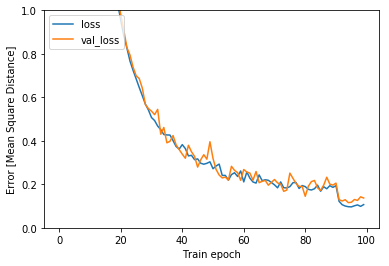

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0,1])
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.xlabel('Train epoch')
_ = plt.ylabel('Error [Mean Square Distance]')


## Applying Model

### Applying a quaternion and a translation

In [0]:
# Defines the loss function to be optimized.
def transform_points(target_points, quaternion_variable, translation_variable):
  return quaternion.rotate(target_points,
                           quaternion_variable) + translation_variable

In [0]:
class Viewer(object):

  def __init__(self, my_vertices):
    my_vertices = np.asarray(my_vertices)
    context = threejs_visualization.build_context()
    light1 = context.THREE.PointLight.new_object(0x808080)
    light1.position.set(10., 10., 10.)
    light2 = context.THREE.AmbientLight.new_object(0x808080)
    lights = (light1, light2)

    material = context.THREE.MeshLambertMaterial.new_object({
        'color': 0xfffacd,
    })

    material_deformed = context.THREE.MeshLambertMaterial.new_object({
        'color': 0xf0fff0,
    })

    camera = threejs_visualization.build_perspective_camera(
        field_of_view=30, position=(10.0, 10.0, 10.0))

    mesh = {'vertices': vertices, 'faces': faces, 'material': material}
    transformed_mesh = {
        'vertices': my_vertices,
        'faces': faces,
        'material': material_deformed
    }
    geometries = threejs_visualization.triangular_mesh_renderer(
        [mesh, transformed_mesh],
        lights=lights,
        camera=camera,
        width=400,
        height=400)

    self.geometries = geometries

  def update(self, transformed_points):
    self.geometries[1].getAttribute('position').copyArray(
        transformed_points.numpy().ravel().tolist())
    self.geometries[1].getAttribute('position').needsUpdate = True

In [0]:
def get_random_transform():
  # Forms a random translation
  with tf.name_scope('translation_variable'):
    random_translation = tf.Variable(
        np.random.uniform(-2.0, 2.0, (3,)), dtype=tf.float32)

  # Forms a random quaternion
  hi = np.pi
  lo = -hi
  random_angles = np.random.uniform(lo, hi, (3,)).astype(np.float32)
  with tf.name_scope('rotation_variable'):
    random_quaternion = tf.Variable(quaternion.from_euler(random_angles))

  return random_quaternion, random_translation

### View initial orientation

In [35]:
random_quaternion, random_translation = get_random_transform()

initial_orientation = transform_points(vertices, random_quaternion,
                                       random_translation).numpy()
viewer = Viewer(initial_orientation)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### View predicted orientation

In [36]:
predicted_transformation = model.predict(initial_orientation[tf.newaxis, :, :])

predicted_inverse_q = quaternion.inverse(predicted_transformation[0, 0:4])
predicted_inverse_t = -predicted_transformation[0, 4:]

predicted_aligned = quaternion.rotate(initial_orientation + predicted_inverse_t, predicted_inverse_q)

viewer = Viewer(predicted_aligned)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>